# CAT VS DOG CLASSIFIER

## Observation-2(Using Transfer Learning)

In [ ]:
#required Model Importation
import tensorflow as tf
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt

# **`Dataset Path Allocation and Extraction`**



In [ ]:
URL = 'https://drive.google.com/drive/folders/1fBDldyiNV4WpRC6rEKGIBdw_bMLNDnsZ?usp=sharing'

In [ ]:
train_dir = os.path.join('/content/drive/MyDrive/Deep Learning Dataset - Cat vs Dog Classifier/dog-cat-full-dataset-master/dog-cat-full-dataset-master/data/train')
validation_dir = os.path.join('/content/drive/MyDrive/Deep Learning Dataset - Cat vs Dog Classifier/dog-cat-full-dataset-master/dog-cat-full-dataset-master/data/test')

**Creating Training and validation(test) dataset**

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 20050 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 5000 files belonging to 2 classes.


**Validating the Seperation Size of validation dataset**

In [ ]:
valdation_batches = tf.data.experimental.cardinality(validation_dataset)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 157


In [ ]:
test_batches = valdation_batches // 5

In [ ]:
test_dataset = validation_dataset.take(test_batches)
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of test batches: 31


In [ ]:
validation_dataset = validation_dataset.skip(test_batches)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of validation batches: 126


In [ ]:
class_names = train_dataset.class_names
class_names

['cats', 'dogs']

# **Visualising the Training Dataset**

**Plot one Image**

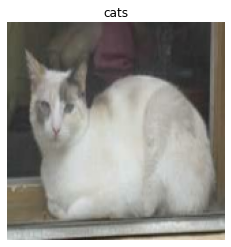

In [ ]:
for image, label in train_dataset.take(1):
    image = image.numpy().astype("uint8")
    plt.imshow(image[0])
    plt.title(class_names[label[0]])
    plt.axis('off')
    plt.show()

**Plotting Multiple training Dataset**

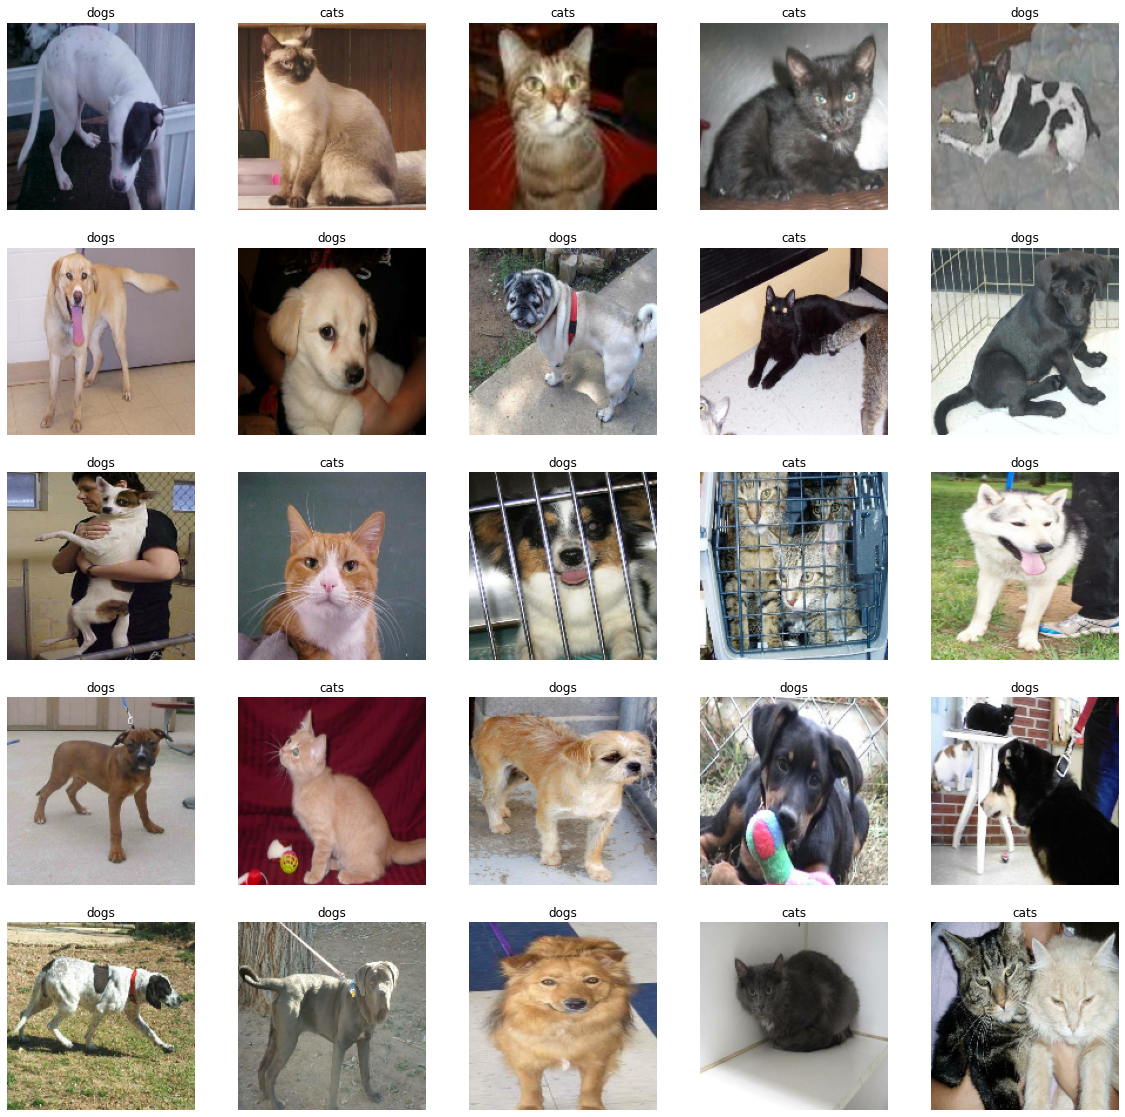

In [ ]:
plt.figure(figsize=(20, 20))
for images, labels in train_dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# **Configuring the Dataset for Performance**

In [ ]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

**Plotting One Augmented Image**

first image shape: (160, 160, 3)
Expaned dims of first image:   (1, 160, 160, 3)


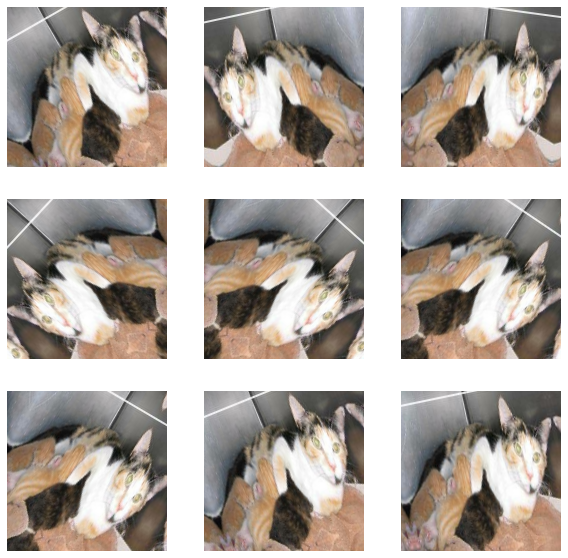

In [ ]:
plt.figure(figsize=(10, 10))
for image, label in train_dataset.take(1):
    first_image = image[0]
    print(f'first image shape: {first_image.shape}')
    expaned_dims_first_image =  tf.expand_dims(first_image, 0)
    print(f'Expaned dims of first image:   {expaned_dims_first_image.shape}')
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        
        augmented_image=data_augmentation(expaned_dims_first_image)
        
        #rescale augmented_image
        augmented_image = augmented_image[0] / 255
        plt.imshow(augmented_image)
        plt.axis('off')

# **RESCALLING THE PIXEL VALUES**


**Creating the Base model from the pre-trained MobileNet V2**

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input

<function keras.applications.mobilenet_v2.preprocess_input>

In [ ]:
IMG_SIZE

(160, 160)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
IMG_SHAPE

(160, 160, 3)

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


**Freezing The Convolutional Base**

**Model Summary**

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

**Adding a Classification Head**

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


**Applying a Dense Layer on Feature batch average**

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


# **Building a Model**

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model

**Compiling the Model**

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**View the trainable variables of model**

In [ ]:
len(model.trainable_variables)


2

**Checking the intial Loss and accuracy on validation dataset**



In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)


126/126 [==============================] - 61s 454ms/step - loss: 0.8378 - accuracy: 0.4805


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.48


# **Training the model**

In [ ]:
EPOCHS = 10
history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    validation_data=validation_dataset)

Epoch 1/10
627/627 [==============================] - 2104s 3s/step - loss: 0.3719 - accuracy: 0.8123 - val_loss: 0.1342 - val_accuracy: 0.9516
Epoch 2/10
627/627 [==============================] - 386s 615ms/step - loss: 0.1871 - accuracy: 0.9192 - val_loss: 0.0876 - val_accuracy: 0.9713
Epoch 3/10
627/627 [==============================] - 392s 625ms/step - loss: 0.1519 - accuracy: 0.9372 - val_loss: 0.0713 - val_accuracy: 0.9773
Epoch 4/10
627/627 [==============================] - 396s 631ms/step - loss: 0.1414 - accuracy: 0.9397 - val_loss: 0.0646 - val_accuracy: 0.9785
Epoch 5/10
627/627 [==============================] - 393s 627ms/step - loss: 0.1329 - accuracy: 0.9446 - val_loss: 0.0601 - val_accuracy: 0.9800
Epoch 6/10
627/627 [==============================] - 385s 613ms/step - loss: 0.1269 - accuracy: 0.9469 - val_loss: 0.0573 - val_accuracy: 0.9813
Epoch 7/10
627/627 [==============================] - 391s 623ms/step - loss: 0.1245 - accuracy: 0.9468 - val_loss: 0.0564 - v

**Plotting the loss and accuracy**

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

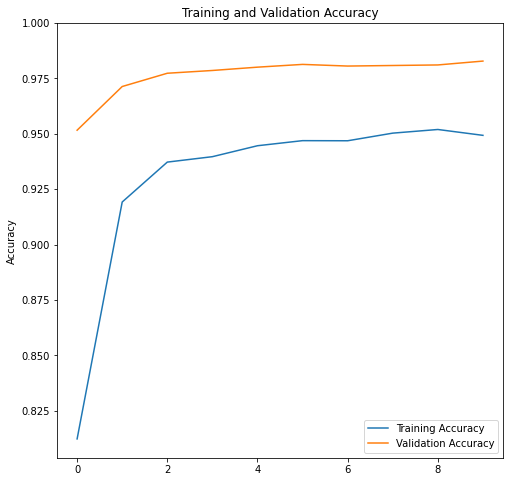

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.show()

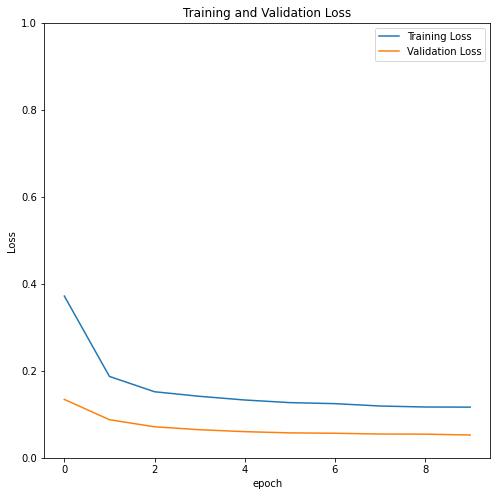

In [ ]:
plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# **Fine tuning of pre-trained model**

In [ ]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


**Unfreezing the top layers of the model**

In [ ]:
base_model.trainable = True
# Fine-tune from this layer onwards
fine_tune_at = 100
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

# **Re-Compile the Model**

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# **Continuous training of Model**

In [ ]:
len(model.trainable_variables)
FINE_TUNE_EPOCHS = 10
TOTAL_EPOCHS =  EPOCHS + FINE_TUNE_EPOCHS
history_fine = model.fit(train_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
627/627 [==============================] - 609s 963ms/step - loss: 0.1059 - accuracy: 0.9583 - val_loss: 0.0425 - val_accuracy: 0.9845
Epoch 11/20
627/627 [==============================] - 600s 956ms/step - loss: 0.0880 - accuracy: 0.9648 - val_loss: 0.0420 - val_accuracy: 0.9860
Epoch 12/20
627/627 [==============================] - 598s 954ms/step - loss: 0.0786 - accuracy: 0.9687 - val_loss: 0.0452 - val_accuracy: 0.9840
Epoch 13/20
627/627 [==============================] - 608s 969ms/step - loss: 0.0710 - accuracy: 0.9724 - val_loss: 0.0375 - val_accuracy: 0.9880
Epoch 14/20
627/627 [==============================] - 603s 961ms/step - loss: 0.0700 - accuracy: 0.9726 - val_loss: 0.0356 - val_accuracy: 0.9885
Epoch 15/20
627/627 [==============================] - 606s 966ms/step - loss: 0.0642 - accuracy: 0.9747 - val_loss: 0.0616 - val_accuracy: 0.9785
Epoch 16/20
627/627 [==============================] - 611s 974ms/step - loss: 0.0587 - accuracy: 0.9773 - val_loss: 0

**Replotting the model of loss and accuracy with Validation Dataset**

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

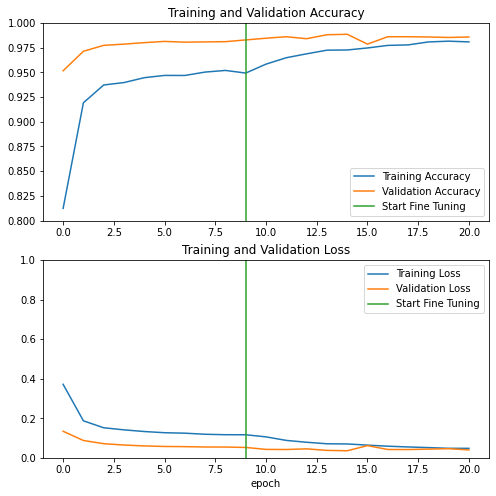

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**Evaluating the Model after tuning on test dataset**

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

31/31 [==============================] - 14s 431ms/step - loss: 0.0352 - accuracy: 0.9889


In [ ]:
print('Test loss :', loss)
print('Test accuracy :', accuracy)

Test loss : 0.03517390415072441
Test accuracy : 0.9889112710952759


# **Predicting the Test Dataset**

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()
print(predictions)

[ -3.1067333  -7.7507815 -14.670601  -11.332804   -2.8122084  -4.2151017
  11.98901   -16.776052  -14.668698   10.068104  -11.110591   10.488556
  12.380764   -3.4635777 -14.722565    9.343873  -14.51162    11.646096
 -13.523426  -13.798392   10.5304     13.44931   -15.839376   10.2136345
  12.458769   -9.814944  -10.513887   13.834737  -10.80756    15.18955
  11.222622   12.295652 ]


In [ ]:
# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1]
Labels:
 [0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 1 1]


# **Plotting the prediction**

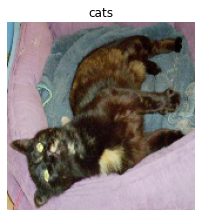

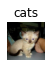

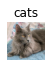

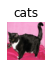

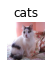

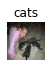

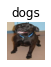

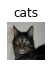

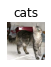

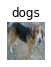

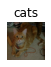

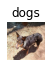

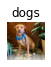

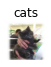

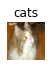

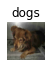

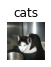

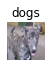

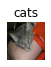

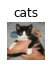

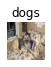

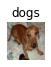

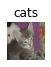

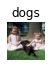

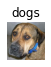

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")
    plt.show()